# Submission 1: Price a European Up-and-out Call Option


## 1. Simulated Paths for the Underlying Share and Counterparty Firm

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Initialize problem parameters
# option maturity
T = 1
# up-and-out barrier
L = 150
# current share price
S0 = 100
# strike price, at-the-money
K = 100
# risk-free rate
risk_free = .08
# volatility
sigma = .3

# counterparty firm current value
v_0 = 200 # Our assumption 
# volatility for the counterparty's firm
sigma_firm = .25
# counterparty's debt, due in one year 
debt = 175
# correlation
corr = .2
# recovery rate
recovery_rate = 0.25

########
#corr_matrix = np.array([[1, corr], [corr, 1]])
sample_sizes = range(1000, 50001, 1000)

In [3]:
#### 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

In [4]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
    return S_0*np.exp(np.cumsum((risk_free_rate-sigma**2/2)*dT + sigma*np.sqrt(dT)*Z,1))


def generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 10, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    share_price_path = pd.DataFrame(share_path(S0, risk_free, sigma, Z=corr_norm_matrix[:,0,], dT=1/timesteps))
    share_price_path = share_price_path.transpose()

    firm_price_path = pd.DataFrame(share_path(v_0, risk_free, sigma_firm, Z=corr_norm_matrix[:,1,], dT=1/timesteps))
    firm_price_path = firm_price_path.transpose()

    return [share_price_path,firm_price_path]  

To double check that the stock prices and firm values monthly returns are correlated, we check them as follows:

In [5]:
#Testing share and firm price correlation
sample_size = 20
test = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size, timesteps = 20000)

share_ret = np.log(test[0])

for i in range(sample_size):
    test[0]['sharelog'] = np.log(test[0][i])
    test[1]['firmlog'] = np.log(test[1][i])
    print(stats.pearsonr(test[0]['sharelog'].diff().dropna(), test[1]['firmlog'].diff().dropna()))

(0.2035028479587627, 6.07336614624919e-186)
(0.1986599648970965, 4.04999708397334e-177)
(0.2016759847597355, 1.3775160789695309e-182)
(0.20364055709605317, 3.381815103189066e-186)
(0.19385401550478024, 1.3726860317349184e-168)
(0.19892212605701942, 1.3666646645127986e-177)
(0.18344242259502544, 7.064732561303709e-151)
(0.20519864966486748, 4.356484560250648e-189)
(0.193927020114363, 1.022531700201078e-168)
(0.19751037260327703, 4.659785935918803e-175)
(0.20393895669991588, 9.495454795149592e-187)
(0.20458792743312265, 5.953557128978809e-188)
(0.2042028358117276, 3.0829601588859696e-187)
(0.19512700379639908, 7.943982338391081e-171)
(0.19603082201925184, 2.003660281095667e-172)
(0.19820752618175266, 2.630853001655849e-176)
(0.20299979761482267, 5.137198920374959e-185)
(0.1966663418793928, 1.4903037901828931e-173)
(0.20319824398313788, 2.214204369119104e-185)
(0.20765530182748704, 1.0810080941108714e-193)


Let's try to simulate the share price with a small number of sample paths and visualize them over the course of 12 months

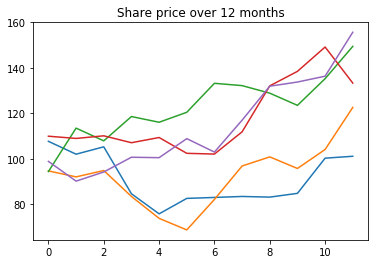

In [23]:
share_and_firm_price_12_months = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 12)
share_price_12_months = share_and_firm_price_12_months[0]
share_price_12_months.plot(title='Share price over 12 months', legend=False)

We can do the same thing to simulate counterparty firm's value

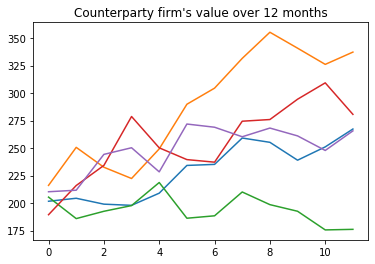

In [7]:
#firm_value_12_months = generate_share_price(v_0, r, sigma_firm, T, sample_size=5)
#firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False)
firm_value_12_months = share_and_firm_price_12_months[1]
firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False)

In fact, we can also simulate the dynamic with finer resolution.

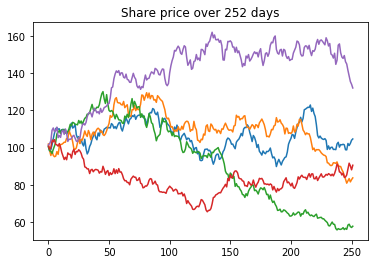

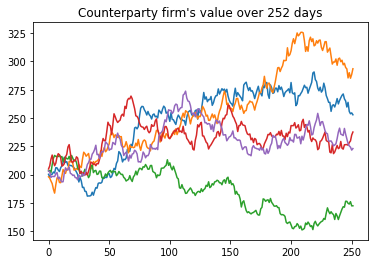

In [8]:
share_and_firm_price_252_days = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 252)
share_price_252_days = share_and_firm_price_252_days[0]
firm_price_252_days = share_and_firm_price_252_days[1]
share_price_252_days.plot(title='Share price over 252 days', legend=False)
firm_price_252_days.plot(title="Counterparty firm's value over 252 days", legend=False)

Let's visualize when the stopped process is appied

In [9]:
def stop(s, cond):
    ret = s.copy()
    r = ret[cond]
    if len(r) > 0:
        print(r)
        ret[r.idxmin():] = 0
    return ret

2     161.483833
3     168.949192
4     181.347422
5     170.405499
6     169.437928
7     196.893265
8     224.207761
9     221.731739
10    215.881820
11    187.312162
Name: 3, dtype: float64
9     151.943503
10    150.294926
11    155.007482
Name: 4, dtype: float64


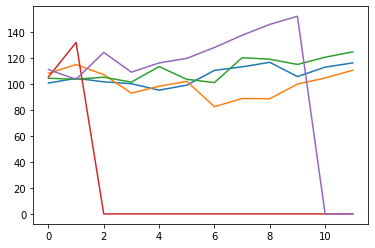

In [10]:
share_price_12_months.apply(lambda s: stop(s, s>L), axis=0).plot(legend=False)

In [11]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

payoff(share_price_12_months, K, L)

array([16.0734419 , 10.47385829, 24.56519536,  0.        ,  0.        ])

Now let's increase the sample size to be able to estimate the mean price more accurately

In [12]:
import datetime

share_price_paths = {}
firm_val_paths = {}


for sample_size in sample_sizes:
    share_val, firm_val = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = sample_size, timesteps = 12)
     
    share_price_paths[sample_size] = share_val
    firm_val_paths[sample_size] = firm_val
    #print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))

In [13]:
%%capture
option_paths = share_price_paths[1000].apply(lambda s: stop(s, s>L), axis=0)

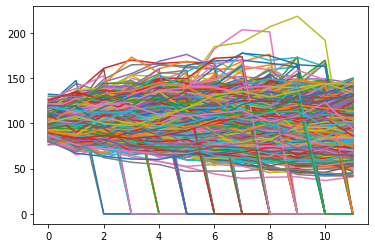

In [14]:
# plot monthly simulations for the lifetime of the option
option_paths.plot(legend=False)

## 2. Monte Carlo Estimates

### 2.1 Default-free Value

In [15]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs
    option_estimate.append(option_price.mean())
    option_std.append(option_price.std()/np.sqrt(sample_size))


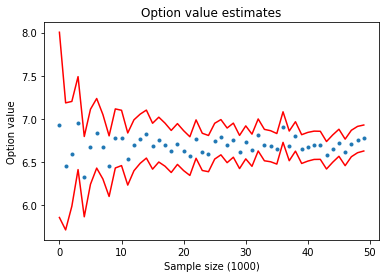

In [16]:
plt.plot(option_estimate, '.')
plt.plot(option_estimate + 3 * np.array(option_std), 'r')
plt.plot(option_estimate - 3 * np.array(option_std), 'r')
plt.title("Option value estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

### 2.2 CVA Adjustment

As per notes, default can only occur at time T, and firm defaults if the firm value is below firm debt amount

In [17]:
def terminal_value(S_0, risk_free_rate, sigma, Z, T): #applies to both firm and stock
    return S_0 * np.exp((risk_free_rate - sigma**2/2) * T + sigma * np.sqrt(T) * Z)

In [18]:
cva_estimate = []
cva_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    cva_estimate.append(amount_lost.mean())
    cva_std.append(amount_lost.std()/np.sqrt(sample_size))
    

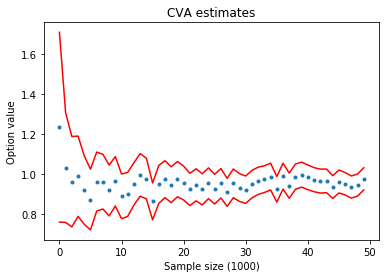

In [19]:
plt.plot(cva_estimate, '.')
plt.plot(cva_estimate + 3 * np.array(cva_std), 'r')
plt.plot(cva_estimate - 3 * np.array(cva_std), 'r')
plt.title("CVA estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

## 3. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA.

In [20]:
option_cva_adjusted_prices = []
option_cva_adjusted_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs

    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    
    option_cva_price = option_price - amount_lost
    
    option_cva_adjusted_prices.append(option_cva_price.mean())
    option_cva_adjusted_std.append(option_cva_price.std()/np.sqrt(sample_size))



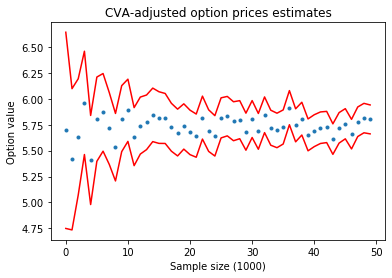

In [21]:
plt.plot(option_cva_adjusted_prices, '.')
plt.plot(option_cva_adjusted_prices + 3 * np.array(option_cva_adjusted_std), 'r')
plt.plot(option_cva_adjusted_prices - 3 * np.array(option_cva_adjusted_std), 'r')
plt.title("CVA-adjusted option prices estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()